In [ ]:
!pip install -r requirements.txt
!pip install ultralytics timm scikit-learn faiss-cpu tdqm

In [3]:
from inference import EmbeddingClassifier
import cv2
import numpy as np
import json
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging


c:\Users\kiennd\miniconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
config = {
    "dataset": {
        "path": "database.pt"
    },
    "model": {
        "path": "model.ckpt",
        "device": "cpu"   # or "cuda" if your env supports it
    },
    "log_level": "INFO"
}

IMAGES_DIR = "../data_images/"
DATA_DIR = "../data_csv/"
RESULTS_DIR = "../results/"

logging.getLogger().setLevel(logging.CRITICAL)


In [5]:
fishial_path = os.path.join(DATA_DIR, "fishial_V7.csv") # Fishial's species for V7
timor_leste_data_path = os.path.join(DATA_DIR, "timor-leste.csv") # Annotation info for ground truth
df_det = pd.read_csv(os.path.join(DATA_DIR, "detection_results.csv"))

# Data preparation

In [4]:
with open("labels.json", "r") as f:
    labels = json.load(f)

valid_species = set(labels.keys())

In [5]:
# Filter for relevant species 
df_tl_ann = pd.read_csv(timor_leste_data_path, encoding="utf-8-sig", header=0, skiprows=1)
df_tl_ann["Species_name"] = df_tl_ann["Species_name"].astype(str).str.strip()

df_filtered = df_tl_ann[df_tl_ann["Species_name"].isin(valid_species)]
image_list = df_filtered["image_file"].tolist()

print(f"Number of images after filtering for relevant species: {len(image_list)}")

Number of images after filtering for relevant species: 193


# Model

In [6]:
y_true = []
y_pred = []
used_images = []   # keep track of which images we actually classified
N = 3

classifier = EmbeddingClassifier(config)
logging.getLogger("classifier").setLevel(logging.CRITICAL)


for i in range(len(image_list)):
    img_name = image_list[i]
    species_rows = df_filtered.loc[df_filtered["image_file"] == img_name, "Species_name"]

    if species_rows.empty:
        print(f"No GT found in df_filtered for {img_name}, skipping.")
        continue

    species = species_rows.values[0]  # ground truth

    image_path = os.path.join(IMAGES_DIR, img_name)
    print(f"\n--- Classifying image {i+1}: {img_name} ---")

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read: {image_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = classifier(img)

    if not results:
        print("No predictions returned, skipping.")
        continue

    # top-1 prediction
    top1 = results[0]

    print("Top predictions:")
    for pred in results:
        print(f"{pred.name}   | accuracy: {pred.accuracy:.3f}")

    # store for later comparison
    y_true.append(species)
    y_pred.append(top1.name)
    used_images.append(img_name)


[2025-12-04 12:59:17] [INFO] - Dataset loaded from database.pt
[2025-12-04 12:59:19] [INFO] - Initializing EmbeddingClassifier...


Loading ViT backbone: beitv2_base_patch16_224.in1k_ft_in22k_in1k
StableEmbeddingModel initialized with ViT backbone: beitv2_base_patch16_224.in1k_ft_in22k_in1k
  Embedding Dim: 512, Num Classes: 639
  ArcFace s: 64.0, m: 0.5
  Backbone out features (ViT embed_dim): 768
  BN in embedding: False, Dropout in embedding: 0.11


[2025-12-04 12:59:20] [INFO] - Torch model loaded from model.ckpt
[2025-12-04 12:59:20] [INFO] - EmbeddingClassifier initialized successfully.
[2025-12-04 12:59:20] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:20] [INFO] - Completed in 0.00 seconds



--- Classifying image 1: 1689120590238.jpg ---
Top predictions:
Alectis ciliaris   | accuracy: 0.100
Caranx crysos   | accuracy: 0.159

--- Classifying image 2: 1689388044927.jpg ---


[2025-12-04 12:59:20] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:20] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.817
Caranx sexfasciatus   | accuracy: 0.821

--- Classifying image 3: 1689388326411.jpg ---
Top predictions:
Caranx lugubris   | accuracy: 0.813
Caranx sexfasciatus   | accuracy: 0.810
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 4: 1689577829534.jpg ---


[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.01 seconds


Top predictions:
Scomberomorus commerson   | accuracy: 0.903
Scomberomorus cavalla   | accuracy: 0.100

--- Classifying image 5: 1689577974563.jpg ---
Top predictions:
Scomberomorus cavalla   | accuracy: 0.943
Scomberomorus commerson   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 6: 1689594468820.jpg ---


[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.00 seconds


Top predictions:
Ariopsis felis   | accuracy: 0.557

--- Classifying image 7: 1689651076768.jpg ---
Top predictions:
Xiphias gladius   | accuracy: 0.850

--- Classifying image 8: 1689651811316.jpg ---


[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:21] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:21] [INFO] - Completed in 0.02 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.902
Scomberomorus cavalla   | accuracy: 0.939
Scomberomorus commerson   | accuracy: 0.900

--- Classifying image 9: 1689652491689.jpg ---
Top predictions:
Scomberomorus cavalla   | accuracy: 0.968
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 10: 1689733035992.jpg ---


[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.01 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.923

--- Classifying image 11: 1689739881340.jpg ---


[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.01 seconds


Top predictions:
Makaira nigricans   | accuracy: 0.845
Kajikia audax   | accuracy: 0.838
Istiophorus albicans   | accuracy: 0.830
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 12: 1689739901296.jpg ---
Top predictions:
Scomberomorus cavalla   | accuracy: 0.942
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 13: 1689740066618.jpg ---


[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.02 seconds


Top predictions:
Scomberomorus commerson   | accuracy: 0.964

--- Classifying image 14: 1689740260887.jpg ---
Top predictions:
Alectis ciliaris   | accuracy: 0.806
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 15: 1689743257346.jpg ---


[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:22] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:22] [INFO] - Completed in 0.00 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.874
Scomberomorus commerson   | accuracy: 0.100

--- Classifying image 16: 1690337039741.jpg ---
Top predictions:
Caranx sexfasciatus   | accuracy: 0.809
Caranx latus   | accuracy: 0.100
Nematistius pectoralis   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 17: 1690349481994.jpg ---


[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx hippos   | accuracy: 0.808

--- Classifying image 18: 1690349481994.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.808

--- Classifying image 19: 1690466885625.jpg ---


[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.887
Caranx sexfasciatus   | accuracy: 0.100
Alectis ciliaris   | accuracy: 0.100

--- Classifying image 20: 1690544392983.jpg ---
Top predictions:
Caranx bartholomaei   | accuracy: 0.843

--- Classifying image 21: 1690544392983.jpg ---


[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx bartholomaei   | accuracy: 0.843

--- Classifying image 22: 1690598682706.jpg ---
Top predictions:
Lutjanus campechanus   | accuracy: 0.683
Rhomboplites aurorubens   | accuracy: 0.222

--- Classifying image 23: 1690599089156.jpg ---


[2025-12-04 12:59:23] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:23] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:24] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:24] [INFO] - Completed in 0.02 seconds


Top predictions:
Lutjanus analis   | accuracy: 0.835

--- Classifying image 24: 1690599089156.jpg ---
Top predictions:
Lutjanus analis   | accuracy: 0.835

--- Classifying image 25: 1690890877921.jpg ---


[2025-12-04 12:59:24] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:24] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:24] [INFO] - Starting search over 1 embeddings


Top predictions:
Epinephelus fasciatus   | accuracy: 0.379
Carassius auratus   | accuracy: 0.274

--- Classifying image 26: 1690890877921.jpg ---


[2025-12-04 12:59:24] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:24] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:24] [INFO] - Completed in 0.01 seconds


Top predictions:
Epinephelus fasciatus   | accuracy: 0.379
Carassius auratus   | accuracy: 0.274

--- Classifying image 27: 1691143949361.jpg ---
Top predictions:
Caranx lugubris   | accuracy: 0.892
Caranx melampygus   | accuracy: 0.100

--- Classifying image 28: 1691197797009.jpg ---


[2025-12-04 12:59:24] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:24] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:24] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:24] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx hippos   | accuracy: 0.100
Caranx sexfasciatus   | accuracy: 0.187

--- Classifying image 29: 1691197797009.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.100
Caranx sexfasciatus   | accuracy: 0.187

--- Classifying image 30: 1691201510682.jpg ---


[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.918

--- Classifying image 31: 1691201635655.jpg ---
Top predictions:
Lutjanus gibbus   | accuracy: 0.803
Lutjanus rivulatus   | accuracy: 0.100

--- Classifying image 32: 1691201728522.jpg ---


[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.02 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.100

--- Classifying image 33: 1691234458029.jpg ---
Top predictions:
Elagatis bipinnulata   | accuracy: 0.962
Seriola lalandi   | accuracy: 0.100

--- Classifying image 34: 1691235083249.jpg ---


[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.933

--- Classifying image 35: 1691235144639.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.100
Thunnus albacares   | accuracy: 0.171
Bagre marinus   | accuracy: 0.158

--- Classifying image 36: 1691235476798.jpg ---


[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:25] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:25] [INFO] - Completed in 0.01 seconds


Top predictions:
Xiphias gladius   | accuracy: 0.813
Thunnus albacares   | accuracy: 0.379

--- Classifying image 37: 1691235509689.jpg ---
Top predictions:
Caranx ignobilis   | accuracy: 0.828
Caranx sexfasciatus   | accuracy: 0.100

--- Classifying image 38: 1691235988859.jpg ---


[2025-12-04 12:59:26] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:26] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:26] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:26] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.856
Thunnus atlanticus   | accuracy: 0.100

--- Classifying image 39: 1691236115459.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.856
Thunnus atlanticus   | accuracy: 0.100

--- Classifying image 40: 1692330985857.jpg ---


[2025-12-04 12:59:26] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:26] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:26] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:26] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx crysos   | accuracy: 0.841

--- Classifying image 41: 1692330985857.jpg ---
Top predictions:
Caranx crysos   | accuracy: 0.841

--- Classifying image 42: 1692413225981.jpg ---


[2025-12-04 12:59:26] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:26] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:26] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:26] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.859

--- Classifying image 43: 1692413842219.jpg ---
Top predictions:
Rhomboplites aurorubens   | accuracy: 0.860

--- Classifying image 44: 1692414093710.jpg ---


[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.00 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.860
Lutjanus campechanus   | accuracy: 0.109

--- Classifying image 45: 1692414486273.jpg ---
No predictions returned, skipping.

--- Classifying image 46: 1692581137223.jpg ---


[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.948
Alectis ciliaris   | accuracy: 0.100

--- Classifying image 47: 1692581157271.jpg ---
Top predictions:
Caranx ignobilis   | accuracy: 0.941
Alectis ciliaris   | accuracy: 0.100

--- Classifying image 48: 1693045597639.jpg ---


[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.02 seconds


Top predictions:
Lutjanus campechanus   | accuracy: 0.611
Diplodus capensis   | accuracy: 0.101

--- Classifying image 49: 1693045767461.jpg ---
Top predictions:
Scomber scombrus   | accuracy: 0.829
Euthynnus alletteratus   | accuracy: 0.816
Scomber japonicus   | accuracy: 0.812

--- Classifying image 50: 1693045954991.jpg ---


[2025-12-04 12:59:27] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:27] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:28] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:28] [INFO] - Completed in 0.00 seconds


Top predictions:
Scomber scombrus   | accuracy: 0.688
Euthynnus alletteratus   | accuracy: 0.228

--- Classifying image 51: 1693046054194.jpg ---
Top predictions:
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 52: 1693046054194.jpg ---


[2025-12-04 12:59:28] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:28] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:28] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:28] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 53: 1693046250037.jpg ---
Top predictions:
Caranx crysos   | accuracy: 0.813

--- Classifying image 54: 1693046250037.jpg ---


[2025-12-04 12:59:28] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:28] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:28] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:28] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx crysos   | accuracy: 0.813

--- Classifying image 55: 1693046470745.jpg ---
Top predictions:
Lutjanus campechanus   | accuracy: 0.611
Diplodus capensis   | accuracy: 0.101

--- Classifying image 56: 1693046578401.jpg ---


[2025-12-04 12:59:28] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:28] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.00 seconds


Top predictions:
Scomber scombrus   | accuracy: 0.812
Scomber japonicus   | accuracy: 0.100

--- Classifying image 57: 1693046853848.jpg ---
No predictions returned, skipping.

--- Classifying image 58: 1693444885638.jpg ---


[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.02 seconds


Top predictions:
Scomberomorus commerson   | accuracy: 0.945
Scomberomorus cavalla   | accuracy: 0.100

--- Classifying image 59: 1693450624018.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.818
Caranx caninus   | accuracy: 0.100
Selene vomer   | accuracy: 0.100

--- Classifying image 60: 1693535715149.jpg ---


[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx hippos   | accuracy: 0.835
Caranx caninus   | accuracy: 0.855
Caranx ignobilis   | accuracy: 0.823

--- Classifying image 61: 1693546581340.jpg ---
Top predictions:
Alectis ciliaris   | accuracy: 0.863
Selene vomer   | accuracy: 0.100

--- Classifying image 62: 1693546778635.jpg ---


[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:29] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:29] [INFO] - Completed in 0.01 seconds


Top predictions:
Makaira nigricans   | accuracy: 0.100
Xiphias gladius   | accuracy: 0.100

--- Classifying image 63: 1693549640994.jpg ---
Top predictions:
Alectis ciliaris   | accuracy: 0.801
Selene vomer   | accuracy: 0.124

--- Classifying image 64: 1693652276403.jpg ---


[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.02 seconds


Top predictions:
Gymnosarda unicolor   | accuracy: 0.594
Katsuwonus pelamis   | accuracy: 0.245

--- Classifying image 65: 1694346646225.jpg ---
Top predictions:
Caranx sexfasciatus   | accuracy: 0.939
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 66: 1694865793188.jpg ---


[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus bohar   | accuracy: 0.832

--- Classifying image 67: 1694867305294.jpg ---


[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.01 seconds


Top predictions:
Belone belone   | accuracy: 0.564

--- Classifying image 68: 1694867312901.jpg ---
Top predictions:
Belone belone   | accuracy: 0.703

--- Classifying image 69: 1695258772293.jpg ---


[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:30] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:30] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx crysos   | accuracy: 0.831

--- Classifying image 70: 1695267680911.jpg ---
Top predictions:
Clupea harengus   | accuracy: 0.640
Salvelinus namaycush   | accuracy: 0.152

--- Classifying image 71: 1695388917511.jpg ---


[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.01 seconds


Top predictions:
Katsuwonus pelamis   | accuracy: 0.981
Sarda sarda   | accuracy: 0.100

--- Classifying image 72: 1695389182703.jpg ---
Top predictions:
Katsuwonus pelamis   | accuracy: 0.973
Sarda sarda   | accuracy: 0.100

--- Classifying image 73: 1695389254664.jpg ---


[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.01 seconds


Top predictions:
Katsuwonus pelamis   | accuracy: 0.973
Sarda sarda   | accuracy: 0.100

--- Classifying image 74: 1695389712651.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Thunnus alalunga   | accuracy: 0.100

--- Classifying image 75: 1695389756695.jpg ---


[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Thunnus alalunga   | accuracy: 0.100

--- Classifying image 76: 1695390143732.jpg ---
Top predictions:
Istiophorus albicans   | accuracy: 0.851
Makaira nigricans   | accuracy: 0.846
Kajikia audax   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.201

--- Classifying image 77: 1695390161790.jpg ---


[2025-12-04 12:59:31] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:31] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.02 seconds


Top predictions:
Istiophorus albicans   | accuracy: 0.851
Makaira nigricans   | accuracy: 0.846
Kajikia audax   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.201

--- Classifying image 78: 1695390184818.jpg ---
Top predictions:
Istiophorus albicans   | accuracy: 0.851
Makaira nigricans   | accuracy: 0.846
Kajikia audax   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.201

--- Classifying image 79: 1695511150791.jpg ---


[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.190
Ariopsis felis   | accuracy: 0.157
Caranx bartholomaei   | accuracy: 0.132
Seriola dumerili   | accuracy: 0.110

--- Classifying image 80: 1695511964208.jpg ---
Top predictions:
Hoplias malabaricus   | accuracy: 0.993

--- Classifying image 81: 1695521758525.jpg ---


[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.01 seconds


Top predictions:
Ariopsis felis   | accuracy: 0.379
Caranx sexfasciatus   | accuracy: 0.311
Clarias gariepinus   | accuracy: 0.141

--- Classifying image 82: 1695691830697.jpg ---
Top predictions:
Lutjanus gibbus   | accuracy: 0.100
Lutjanus mahogoni   | accuracy: 0.100

--- Classifying image 83: 1695713427558.jpg ---


[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:32] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:32] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus mahogoni   | accuracy: 0.100
Amphilophus citrinellus   | accuracy: 0.304
Lutjanus gibbus   | accuracy: 0.102

--- Classifying image 84: 1695734455651.jpg ---
Top predictions:
Elagatis bipinnulata   | accuracy: 0.282
Hypanus americanus   | accuracy: 0.271
Ocyurus chrysurus   | accuracy: 0.128

--- Classifying image 85: 1695734906095.jpg ---


[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.01 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.931
Kajikia audax   | accuracy: 0.931

--- Classifying image 86: 1695735175273.jpg ---
Top predictions:
Scomberomorus commerson   | accuracy: 0.904
Scomberomorus cavalla   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 87: 1695735361459.jpg ---


[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.01 seconds


Top predictions:
Scarus coeruleus   | accuracy: 0.203

--- Classifying image 88: 1695735670368.jpg ---
Top predictions:
Scomberomorus cavalla   | accuracy: 0.817
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 89: 1695735670368.jpg ---


[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.02 seconds


Top predictions:
Scomberomorus cavalla   | accuracy: 0.817
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 90: 1696333279652.jpg ---
Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Lutjanus vivanus   | accuracy: 0.100
Lutjanus campechanus   | accuracy: 0.255

--- Classifying image 91: 1696335870241.jpg ---


[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:33] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:33] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus jocu   | accuracy: 0.334
Lutjanus analis   | accuracy: 0.294

--- Classifying image 92: 1696496895174.jpg ---
Top predictions:
Hiodon alosoides   | accuracy: 0.318
Pachymetopon blochii   | accuracy: 0.162
Hypophthalmichthys molitrix   | accuracy: 0.140
Anisotremus surinamensis   | accuracy: 0.119

--- Classifying image 93: 1696677986326.jpg ---


[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.02 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 94: 1696677986326.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 95: 1696945542849.jpg ---


[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.02 seconds


Top predictions:
Ictalurus punctatus   | accuracy: 0.100
Ameiurus catus   | accuracy: 0.100
Ameiurus nebulosus   | accuracy: 0.138
Ictalurus furcatus   | accuracy: 0.120

--- Classifying image 96: 1696946750249.jpg ---
Top predictions:
Lutjanus gibbus   | accuracy: 0.862

--- Classifying image 97: 1696947493558.jpg ---


[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.00 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 98: 1696947493558.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 99: 1697005652932.jpg ---


[2025-12-04 12:59:34] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:34] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.01 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Rutilus rutilus   | accuracy: 0.466

--- Classifying image 100: 1697012766699.jpg ---
Top predictions:
Lutjanus campechanus   | accuracy: 0.868

--- Classifying image 101: 1697114382541.jpg ---


[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.822
Alectis ciliaris   | accuracy: 0.100
Caranx crysos   | accuracy: 0.196

--- Classifying image 102: 1697114451439.jpg ---
Top predictions:
Amphilophus citrinellus   | accuracy: 0.431
Rhomboplites aurorubens   | accuracy: 0.238

--- Classifying image 103: 1697114533401.jpg ---


[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.806
Rhomboplites aurorubens   | accuracy: 0.100

--- Classifying image 104: 1697115180424.jpg ---


[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.00 seconds


Top predictions:
Seriola dumerili   | accuracy: 0.635

--- Classifying image 105: 1697115186816.jpg ---
Top predictions:
Seriola dumerili   | accuracy: 0.639

--- Classifying image 106: 1697115495415.jpg ---


[2025-12-04 12:59:35] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:35] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.00 seconds


Top predictions:
Seriola dumerili   | accuracy: 0.454
Rhomboplites aurorubens   | accuracy: 0.241
Lutjanus campechanus   | accuracy: 0.109

--- Classifying image 107: 1697115710031.jpg ---
Top predictions:
Seriola dumerili   | accuracy: 0.954

--- Classifying image 108: 1697167269521.jpg ---


[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus johnii   | accuracy: 0.801

--- Classifying image 109: 1697192142521.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.341

--- Classifying image 110: 1697192142521.jpg ---


[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.341

--- Classifying image 111: 1697269146308.jpg ---
Top predictions:
Lichia amia   | accuracy: 0.313
Katsuwonus pelamis   | accuracy: 0.171
Scomberoides commersonnianus   | accuracy: 0.142

--- Classifying image 112: 1697269648589.jpg ---


[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:36] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx ruber   | accuracy: 0.997

--- Classifying image 113: 1697271152607.jpg ---
Top predictions:
Caranx bartholomaei   | accuracy: 0.833

--- Classifying image 114: 1697271152607.jpg ---


[2025-12-04 12:59:36] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx bartholomaei   | accuracy: 0.833

--- Classifying image 115: 1697272759438.jpg ---
Top predictions:
Bagre marinus   | accuracy: 0.100
Caranx hippos   | accuracy: 0.657

--- Classifying image 116: 1697272759438.jpg ---


[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.02 seconds


Top predictions:
Bagre marinus   | accuracy: 0.100
Caranx hippos   | accuracy: 0.657

--- Classifying image 117: 1697273193293.jpg ---
Top predictions:
Acanthocybium solandri   | accuracy: 0.846

--- Classifying image 118: 1697505523144.jpg ---


[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Lutjanus bohar   | accuracy: 0.210

--- Classifying image 119: 1697506247065.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.846
Rhomboplites aurorubens   | accuracy: 0.826
Etelis oculatus   | accuracy: 0.100

--- Classifying image 120: 1697506294036.jpg ---


[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:37] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:37] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.841
Rhomboplites aurorubens   | accuracy: 0.109

--- Classifying image 121: 1697506355974.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.851

--- Classifying image 122: 1697506406466.jpg ---


[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.901

--- Classifying image 123: 1697506536349.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Pimelodus maculatus   | accuracy: 0.280
Carassius auratus   | accuracy: 0.271
Rhomboplites aurorubens   | accuracy: 0.100

--- Classifying image 124: 1697506620470.jpg ---


[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.02 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Lutjanus campechanus   | accuracy: 0.159

--- Classifying image 125: 1697506693057.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Carassius auratus   | accuracy: 0.201

--- Classifying image 126: 1697698487485.jpg ---


[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.00 seconds


Top predictions:
Ameiurus melas   | accuracy: 0.806
Ameiurus nebulosus   | accuracy: 0.803
Ameiurus catus   | accuracy: 0.100
Ameiurus natalis   | accuracy: 0.100

--- Classifying image 127: 1697699933364.jpg ---
Top predictions:
Caranx ruber   | accuracy: 0.805
Caranx crysos   | accuracy: 0.802
Caranx sexfasciatus   | accuracy: 0.100

--- Classifying image 128: 1697864502865.jpg ---


[2025-12-04 12:59:38] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:38] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.00 seconds


Top predictions:
Lepisosteus platostomus   | accuracy: 0.182
Lepisosteus oculatus   | accuracy: 0.131
Pimelodus maculatus   | accuracy: 0.104
Pylodictis olivaris   | accuracy: 0.101

--- Classifying image 129: 1697864667586.jpg ---
Top predictions:
Lepisosteus platostomus   | accuracy: 0.902

--- Classifying image 130: 1697864792743.jpg ---


[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.00 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Rutilus rutilus   | accuracy: 0.132

--- Classifying image 131: 1697864893088.jpg ---
Top predictions:
Lachnolaimus maximus   | accuracy: 0.503
Selene vomer   | accuracy: 0.121

--- Classifying image 132: 1697865090545.jpg ---


[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.00 seconds


Top predictions:
Pimelodus maculatus   | accuracy: 0.465
Lachnolaimus maximus   | accuracy: 0.262

--- Classifying image 133: 1698056471266.jpg ---
Top predictions:
Pimelodus maculatus   | accuracy: 0.780

--- Classifying image 134: 1698062202674.jpg ---


[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus griseus   | accuracy: 0.100
Lutjanus jocu   | accuracy: 0.271
Lutjanus argentimaculatus   | accuracy: 0.169

--- Classifying image 135: 1698062431562.jpg ---
Top predictions:
Lutjanus johnii   | accuracy: 0.801

--- Classifying image 136: 1698064010523.jpg ---


[2025-12-04 12:59:39] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:39] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus campechanus   | accuracy: 0.933

--- Classifying image 137: 1698141339810.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100

--- Classifying image 138: 1698141339810.jpg ---


[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100

--- Classifying image 139: 1698143082765.jpg ---
Top predictions:
Alectis ciliaris   | accuracy: 0.809
Selene vomer   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.179

--- Classifying image 140: 1698143082765.jpg ---


[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.02 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.809
Selene vomer   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.179

--- Classifying image 141: 1698143235892.jpg ---
Top predictions:
Katsuwonus pelamis   | accuracy: 0.100

--- Classifying image 142: 1698274064708.jpg ---


[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:40] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:40] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.173

--- Classifying image 143: 1698318241974.jpg ---
Top predictions:
Lutjanus bohar   | accuracy: 0.822

--- Classifying image 144: 1698324089147.jpg ---


[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.376

--- Classifying image 145: 1698527855359.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.893
Lutjanus campechanus   | accuracy: 0.880

--- Classifying image 146: 1698528173571.jpg ---


[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx melampygus   | accuracy: 0.919
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 147: 1698528209061.jpg ---
Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Lutjanus campechanus   | accuracy: 0.479

--- Classifying image 148: 1698528308697.jpg ---


[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.820
Seriola dumerili   | accuracy: 0.173

--- Classifying image 149: 1698528308697.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.820
Seriola dumerili   | accuracy: 0.173

--- Classifying image 150: 1698528467655.jpg ---


[2025-12-04 12:59:41] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:41] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.893
Lutjanus campechanus   | accuracy: 0.880

--- Classifying image 151: 1698528616835.jpg ---
Top predictions:
Caranx lugubris   | accuracy: 0.871
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 152: 1698528638801.jpg ---


[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus campechanus   | accuracy: 0.924

--- Classifying image 153: 1698528638801.jpg ---
Top predictions:
Lutjanus campechanus   | accuracy: 0.924

--- Classifying image 154: 1698546478939.jpg ---


[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.00 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.812
Caranx crysos   | accuracy: 0.820

--- Classifying image 155: 1698546986877.jpg ---
Top predictions:
Caranx melampygus   | accuracy: 0.814
Thunnus albacares   | accuracy: 0.932

--- Classifying image 156: 1698547581641.jpg ---


[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:42] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:42] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus carponotatus   | accuracy: 0.120

--- Classifying image 157: 1698548194367.jpg ---
Top predictions:
Lutjanus bohar   | accuracy: 0.956

--- Classifying image 158: 1698549061480.jpg ---


[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.00 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.954
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 159: 1698660942801.jpg ---
Top predictions:
Clarias gariepinus   | accuracy: 0.302
Pimelodus maculatus   | accuracy: 0.276
Clarias batrachus   | accuracy: 0.233

--- Classifying image 160: 1698661235894.jpg ---


[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.01 seconds


Top predictions:
Ariopsis felis   | accuracy: 0.100
Clarias batrachus   | accuracy: 0.145

--- Classifying image 161: 1698661390954.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Bagre marinus   | accuracy: 0.721

--- Classifying image 162: 1698661541066.jpg ---


[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx lugubris   | accuracy: 0.827

--- Classifying image 163: 1698661562885.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.802

--- Classifying image 164: 1698662104886.jpg ---


[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:43] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:43] [INFO] - Completed in 0.00 seconds


Top predictions:
Scorpaenichthys marmoratus   | accuracy: 0.650

--- Classifying image 165: 1698662651172.jpg ---
Top predictions:
Semotilus atromaculatus   | accuracy: 0.641

--- Classifying image 166: 1698662758223.jpg ---


[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.109

--- Classifying image 167: 1698662908475.jpg ---
Top predictions:
Lutjanus gibbus   | accuracy: 0.460
Lutjanus bohar   | accuracy: 0.410

--- Classifying image 168: 1698663806513.jpg ---


[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.00 seconds


Top predictions:
Pylodictis olivaris   | accuracy: 0.224
Megalops atlanticus   | accuracy: 0.110
Selene vomer   | accuracy: 0.100

--- Classifying image 169: 1698740072533.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.812

--- Classifying image 170: 1698740471563.jpg ---


[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.701

--- Classifying image 171: 1698740970816.jpg ---
Top predictions:
Sphyrna zygaena   | accuracy: 0.814

--- Classifying image 172: 1698741342007.jpg ---


[2025-12-04 12:59:44] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:44] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds


Top predictions:
Megalops atlanticus   | accuracy: 0.197
Seriola dumerili   | accuracy: 0.171
Thunnus albacares   | accuracy: 0.145
Pylodictis olivaris   | accuracy: 0.112

--- Classifying image 173: 1698741342007.jpg ---
Top predictions:
Megalops atlanticus   | accuracy: 0.197
Seriola dumerili   | accuracy: 0.171
Thunnus albacares   | accuracy: 0.145
Pylodictis olivaris   | accuracy: 0.112

--- Classifying image 174: 1698884042665.jpg ---


[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds


Top predictions:
Lates calcarifer   | accuracy: 0.100
Lutjanus argentimaculatus   | accuracy: 0.688

--- Classifying image 175: 1698926218599.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Rhomboplites aurorubens   | accuracy: 0.557
Seriola dumerili   | accuracy: 0.303

--- Classifying image 176: 1698926724684.jpg ---


[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.872

--- Classifying image 177: 1698927145975.jpg ---
Top predictions:
Seriola dumerili   | accuracy: 0.216
Rutilus rutilus   | accuracy: 0.186
Rhomboplites aurorubens   | accuracy: 0.161

--- Classifying image 178: 1698927262789.jpg ---


[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.266

--- Classifying image 179: 1698927784464.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Rhomboplites aurorubens   | accuracy: 0.405
Seriola dumerili   | accuracy: 0.300

--- Classifying image 180: 1698928222909.jpg ---


[2025-12-04 12:59:45] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:45] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.01 seconds


Top predictions:
Seriola rivoliana   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.173

--- Classifying image 181: 1698928321548.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.825
Rhomboplites aurorubens   | accuracy: 0.100

--- Classifying image 182: 1698928724030.jpg ---


[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.01 seconds
[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.801

--- Classifying image 183: 1699164458540.jpg ---
Top predictions:
Lutjanus bohar   | accuracy: 0.501
Rhomboplites aurorubens   | accuracy: 0.129

--- Classifying image 184: 1699167222100.jpg ---


[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.00 seconds


Top predictions:
Amia calva   | accuracy: 0.449
Tinca tinca   | accuracy: 0.255

--- Classifying image 185: 1699167338210.jpg ---
Top predictions:
Selene vomer   | accuracy: 0.393

--- Classifying image 186: 1699355005032.jpg ---


[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:46] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:46] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus alalunga   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100

--- Classifying image 187: 1699355166176.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.666

--- Classifying image 188: 1699355166176.jpg ---


[2025-12-04 12:59:47] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:47] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:47] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:47] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.666

--- Classifying image 189: 1699355371850.jpg ---
Top predictions:
Thunnus alalunga   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.640
Caranx sexfasciatus   | accuracy: 0.117

--- Classifying image 190: 1699355371850.jpg ---


[2025-12-04 12:59:47] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:47] [INFO] - Completed in 0.02 seconds
[2025-12-04 12:59:47] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:47] [INFO] - Completed in 0.00 seconds


Top predictions:
Thunnus alalunga   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.640
Caranx sexfasciatus   | accuracy: 0.117

--- Classifying image 191: 1699356149974.jpg ---
Top predictions:
Katsuwonus pelamis   | accuracy: 0.100

--- Classifying image 192: 1699356276708.jpg ---


[2025-12-04 12:59:47] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:47] [INFO] - Completed in 0.00 seconds
[2025-12-04 12:59:47] [INFO] - Starting search over 1 embeddings
[2025-12-04 12:59:47] [INFO] - Completed in 0.00 seconds


Top predictions:
Xiphias gladius   | accuracy: 0.225
Istiophorus albicans   | accuracy: 0.204

--- Classifying image 193: 1699356483694.jpg ---
Top predictions:
Caranx crysos   | accuracy: 0.580
Caranx ignobilis   | accuracy: 0.139


In [7]:
df_eval = pd.DataFrame({
    "image_file": used_images,
    "ground_truth": y_true,
    "prediction": y_pred,
})

# 1 = match, 0 = mismatch
df_eval["match"] = (df_eval["ground_truth"] == df_eval["prediction"]).astype(int)

pd.set_option('display.width', 100)
print(df_eval)

df_eval.to_csv(RESULTS_DIR + "630_classification.csv", index=False)

num_match = (df_eval["match"] == 1).sum()
num_mismatch = (df_eval["match"] == 0).sum()

print("Matches :", num_match)
print("Mismatches :", num_mismatch)



            image_file             ground_truth               prediction  match
0    1689120590238.jpg      Caranx sexfasciatus         Alectis ciliaris      0
1    1689388044927.jpg          Caranx lugubris         Caranx ignobilis      0
2    1689388326411.jpg          Caranx lugubris          Caranx lugubris      1
3    1689577829534.jpg  Scomberomorus commerson  Scomberomorus commerson      1
4    1689577974563.jpg  Scomberomorus commerson    Scomberomorus cavalla      0
..                 ...                      ...                      ...    ...
186  1699355371850.jpg         Caranx ignobilis         Thunnus alalunga      0
187  1699355371850.jpg         Caranx ignobilis         Thunnus alalunga      0
188  1699356149974.jpg    Decapterus macarellus       Katsuwonus pelamis      0
189  1699356276708.jpg    Decapterus macarellus          Xiphias gladius      0
190  1699356483694.jpg        Caranx melampygus            Caranx crysos      0

[191 rows x 4 columns]
Matches : 32
Mis

Ground-truth species (used as true classes): ['Acanthocybium solandri', 'Alectis ciliaris', 'Caranx ignobilis', 'Caranx lugubris', 'Caranx melampygus', 'Caranx sexfasciatus', 'Decapterus macarellus', 'Elagatis bipinnulata', 'Katsuwonus pelamis', 'Lethrinus obsoletus', 'Lutjanus bohar', 'Lutjanus fulviflamma', 'Lutjanus fulvus', 'Lutjanus gibbus', 'Lutjanus johnii', 'Lutjanus kasmira', 'Lutjanus rivulatus', 'Scomberoides lysan', 'Scomberomorus commerson', 'Seriola dumerili', 'Tylosurus crocodilus']
Labels used (in order): ['Acanthocybium solandri', 'Alectis ciliaris', 'Caranx ignobilis', 'Caranx lugubris', 'Caranx melampygus', 'Caranx sexfasciatus', 'Decapterus macarellus', 'Elagatis bipinnulata', 'Katsuwonus pelamis', 'Lethrinus obsoletus', 'Lutjanus bohar', 'Lutjanus fulviflamma', 'Lutjanus fulvus', 'Lutjanus gibbus', 'Lutjanus johnii', 'Lutjanus kasmira', 'Lutjanus rivulatus', 'Scomberoides lysan', 'Scomberomorus commerson', 'Seriola dumerili', 'Tylosurus crocodilus', 'Non-objective'

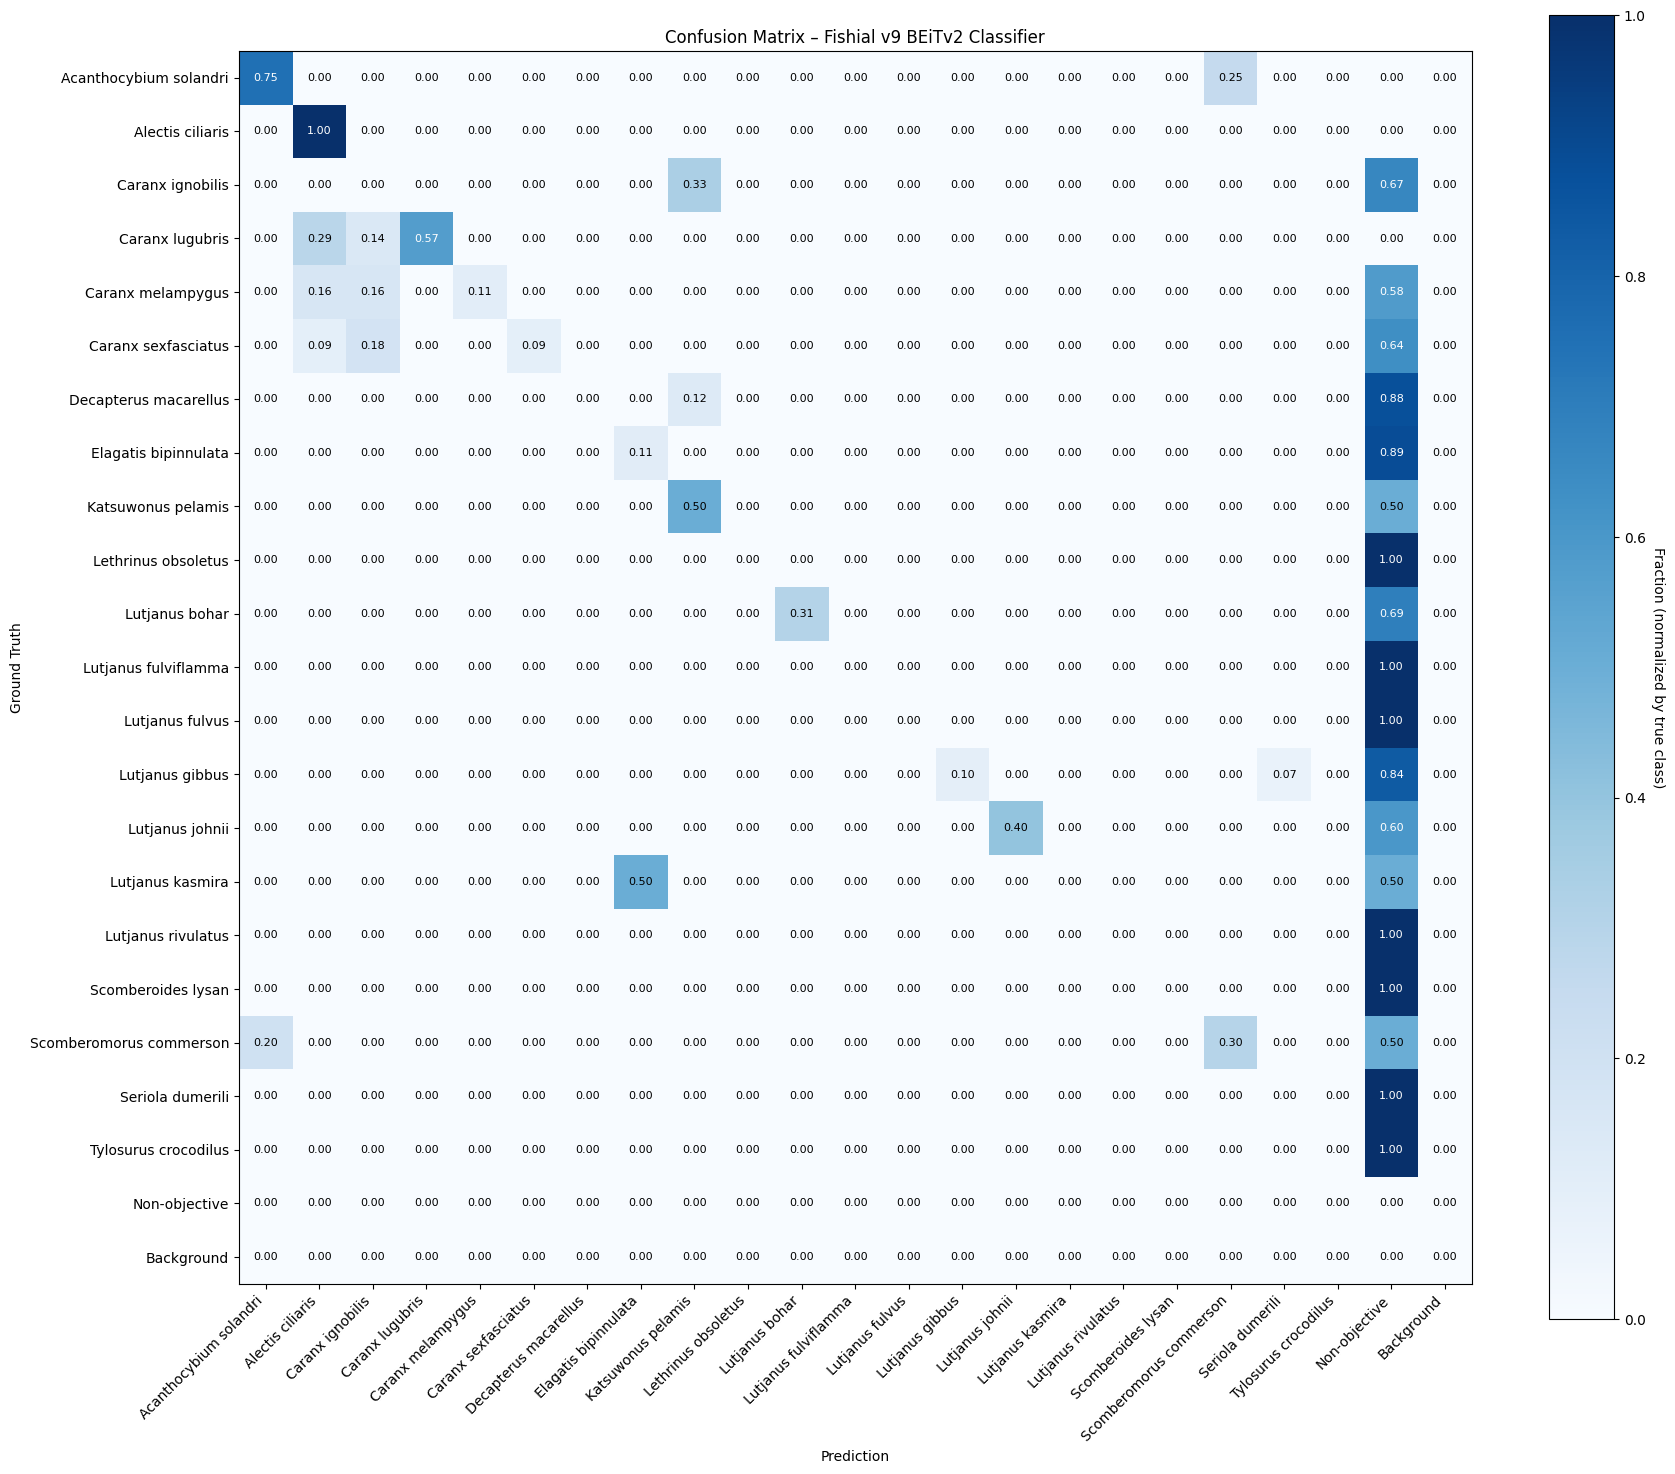

In [4]:

from sklearn.metrics import confusion_matrix

# --- SETTINGS ---
CSV = "../results/630_classification.csv"   # update path if needed
OUT_NONOBJ = "nonobjective_predictions_counts.csv"  # optional output
BACKGROUND = "Background"
NON_OBJECTIVE = "Non-objective"

# --- Load and lowercase columns ---
df = pd.read_csv(CSV)
df.columns = [c.strip().lower() for c in df.columns]

# --- Basic checks ---
if "ground_truth" not in df.columns or "prediction" not in df.columns:
    raise KeyError("CSV must contain 'ground_truth' and 'prediction' columns (case-insensitive).")

# --- Preserve original prediction, and map NaNs to BACKGROUND ---
df["prediction_original"] = df["prediction"].copy()
df["prediction_original"] = df["prediction_original"].fillna(BACKGROUND).astype(str)

# Also normalize ground truth missing values -> BACKGROUND
df["ground_truth"] = df["ground_truth"].fillna(BACKGROUND).astype(str)

# --- Determine relevant species = those that appear in ground truth (exclude BACKGROUND if present) ---
gt_species = sorted([s for s in df["ground_truth"].unique() if s != BACKGROUND])
print("Ground-truth species (used as true classes):", gt_species)

def map_pred_for_cm(p):
    if p == BACKGROUND:
        return BACKGROUND
    if p in gt_species:
        return p
    return NON_OBJECTIVE

df["prediction_mapped"] = df["prediction_original"].apply(map_pred_for_cm)

# Ground truth mapping: keep ground truth as-is, but ensure BACKGROUND label stays BACKGROUND
# (we already filled NaNs with BACKGROUND)
df["ground_truth_mapped"] = df["ground_truth"]

# --- Build final label order: all gt species + non-objective + background ---
unique_species = gt_species + [NON_OBJECTIVE, BACKGROUND]
print("Labels used (in order):", unique_species)

# --- Build arrays for confusion matrix ---
y_true = df["ground_truth_mapped"].values
y_pred = df["prediction_mapped"].values

# --- Compute normalized confusion matrix (by true class) ---
cm = confusion_matrix(y_true, y_pred, labels=unique_species, normalize="true")

# --- Plot (your requested style) ---
fig, ax = plt.subplots(figsize=(18, 15))

# Heatmap
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Fraction (normalized by true class)", rotation=-90, va="bottom")

# Tick labels
ax.set_xticks(np.arange(len(unique_species)))
ax.set_yticks(np.arange(len(unique_species)))
ax.set_xticklabels(unique_species)
ax.set_yticklabels(unique_species)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_title("Confusion Matrix – Fishial v9 BEiTv2 Classifier")

# Turn off grid
ax.grid(False)

# Add the values in each cell (formatted as fractions .2f)
max_val = cm.max() if cm.size > 0 else 1
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        text_color = "white" if val > max_val / 2 else "black"
        ax.text(
            j, i, f"{val:.2f}",
            ha="center", va="center",
            color=text_color,
            fontsize=8
        )

plt.tight_layout()
plt.show()


In [9]:
df_class = pd.read_csv(os.path.join(RESULTS_DIR, "630_classification.csv"))
df_traits = pd.read_csv(os.path.join(DATA_DIR, "fish_traits.csv"), encoding="latin1")
df_tl_ann = pd.read_csv(timor_leste_data_path, encoding="utf-8-sig", header=0, skiprows=1)

In [10]:
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Extract arrays
matched = df_class.loc[df_class["status"] == "MATCH", "image_file"].tolist()
mismatched = df_class.loc[df_class["status"] == "MISMATCH", "image_file"].tolist()

print("Number of matches:", len(matched))
print("Number of mismatches:", len(mismatched))

Number of matches: 32
Number of mismatches: 159


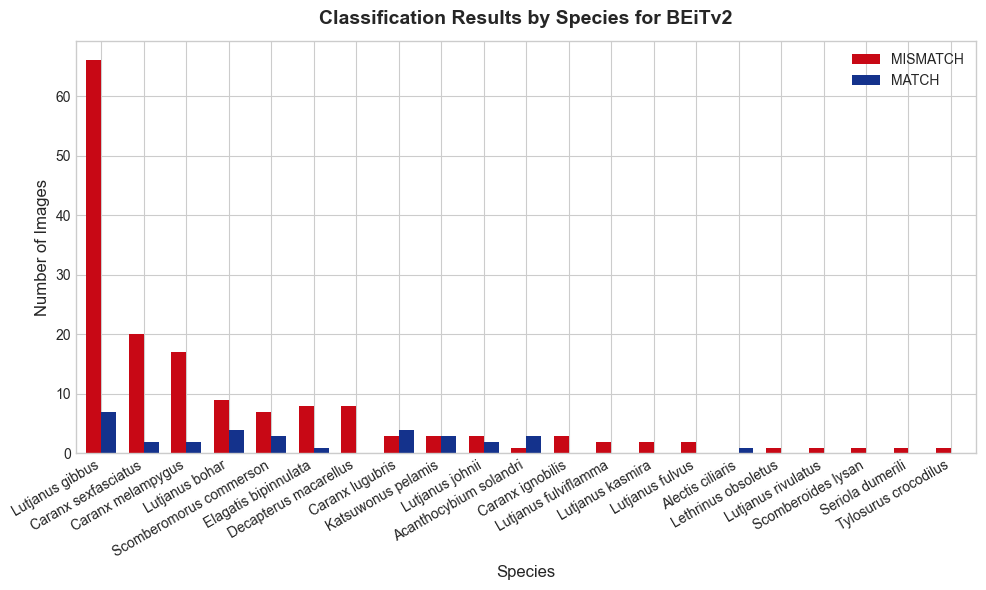

In [11]:
# Config
GROUP_BY = "ground_truth"

# Determine match status
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Summarize
summary = df_class.groupby([GROUP_BY, "status"]).size().unstack(fill_value=0)

# Sort by total count
summary = summary.loc[summary.sum(axis=1).sort_values(ascending=False).index]

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#c80815", "#14328C"]  # red for MISMATCH, blue for MATCH
summary = summary[["MISMATCH", "MATCH"]]

summary.plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.7,
    edgecolor="none",
    figsize=(10,6)
)

plt.title(f"Classification Results by Species for BEiTv2", fontsize=14, weight="semibold", pad=12)
plt.xlabel("Species", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.legend(frameon=False)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Total images counted: 191
Total represented in plot: 191 (should equal Total images)


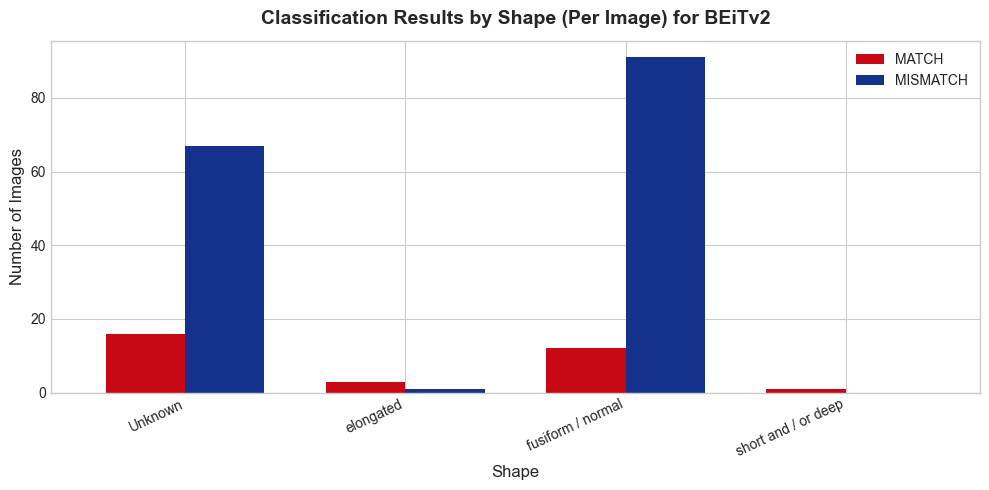

In [12]:
#  Config
TRAIT_COLUMN = "shape"

# Normalize column names (lowercase for consistent joins)
df_class.columns = [c.strip().lower() for c in df_class.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_class.merge(df_traits, left_on="ground_truth", right_on="species_name", how="left")

# If the chosen trait is missing, create it so nothing is dropped
if TRAIT_COLUMN not in df.columns:
    df[TRAIT_COLUMN] = "Unknown"

# Make sure trait has no NaNs so every row is counted
df[TRAIT_COLUMN] = df[TRAIT_COLUMN].fillna("Unknown")

# Sanity check: this should be your total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-trait x worked counts (counts rows/images)
summary = df.groupby([TRAIT_COLUMN, "status"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]

summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title(f"Classification Results by {TRAIT_COLUMN.capitalize()} (Per Image) for BEiTv2", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel(TRAIT_COLUMN.capitalize(), fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Rows after merge: 191


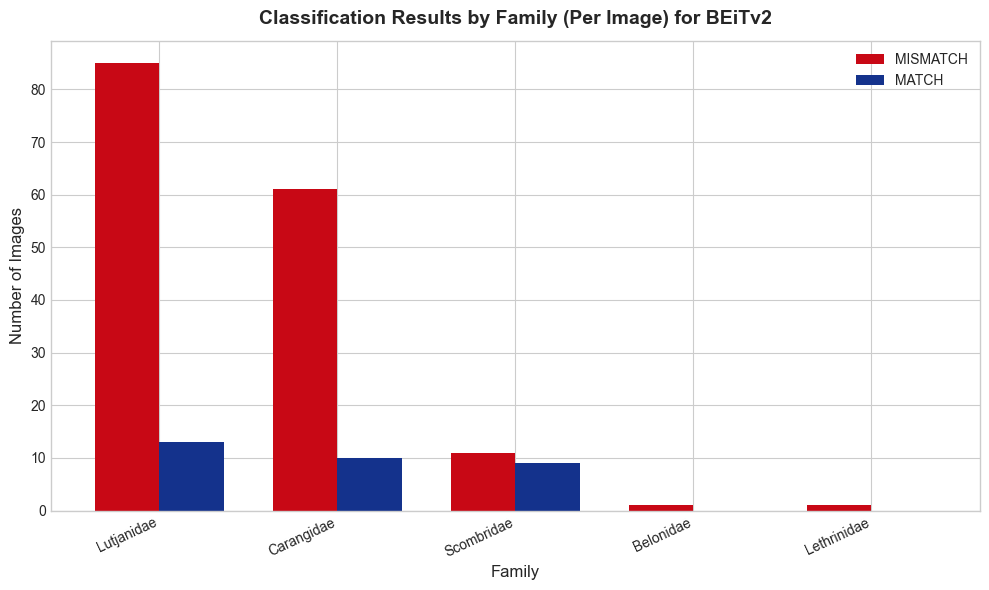

In [16]:
SPECIES_COL_CSV = "Species_name"
FAMILY_COL_CSV = "Family"

# 1) Compute MATCH / MISMATCH
df_class["status"] = (df_class["prediction"] == df_class["ground_truth"])

# Normalize names
def _norm(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower()

df_class["_gt_norm"] = _norm(df_class["ground_truth"])
df_tl_ann["_species_norm"] = _norm(df_tl_ann[SPECIES_COL_CSV])

# Drop duplicates so one species only maps to one Family
df_tl_ann_unique = df_tl_ann.drop_duplicates(subset="_species_norm", keep="first")

# 2) Merge to get Family for each image
df_all = df_class.merge(
    df_tl_ann_unique[["_species_norm", FAMILY_COL_CSV]],
    left_on="_gt_norm",
    right_on="_species_norm",
    how="left"
)
df_all[FAMILY_COL_CSV] = df_all[FAMILY_COL_CSV].fillna("Unknown")

print("Rows after merge:", len(df_all))  # should be equal to len(df_class)

# 3) Group and count by Family + status
summary = df_all.groupby([FAMILY_COL_CSV, "status"]).size().unstack(fill_value=0)
summary = summary.loc[summary.sum(axis=1).sort_values(ascending=False).index]

# 4) Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#c80815", "#14328C"]  # red = mismatch, blue = match

summary.rename(columns={False: "MISMATCH", True: "MATCH"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title("Classification Results by Family (Per Image) for BEiTv2", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Family", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Total images counted: 191
Total represented in plot: 191 (should equal Total images)


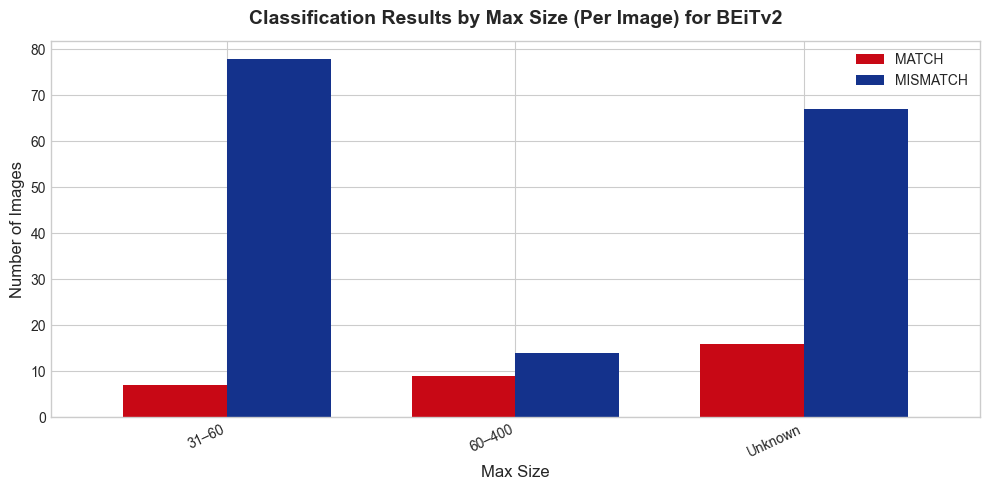

In [17]:
MAX_SIZE_COL = "max_size"
BIN_METHOD = "quantile"
N_BINS = 3
FIXED_BINS = None

# Normalize column names (lowercase for consistent joins)
df_class.columns = [c.strip().lower() for c in df_class.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Ensure max_size is numeric in traits
if MAX_SIZE_COL not in df_traits.columns:
    raise ValueError(f"Column '{MAX_SIZE_COL}' not found in traits file.")
df_traits[MAX_SIZE_COL] = pd.to_numeric(df_traits[MAX_SIZE_COL], errors="coerce")

# Build size bins on the traits table (by species)
size_series = df_traits[MAX_SIZE_COL].dropna()
if BIN_METHOD == "quantile":
    # Create quantile bins with readable labels
    # Drop duplicate edges if data has ties
    q = np.linspace(0, 1, N_BINS + 1)
    edges = np.unique(np.quantile(size_series, q))
    # If not enough unique edges (too many duplicates), fall back to fixed-width
    if len(edges) < 3:
        BIN_METHOD = "fixed"
        FIXED_BINS = np.linspace(size_series.min(), size_series.max(), min(N_BINS, 6) + 1)
    else:
        bins = edges
elif BIN_METHOD == "fixed":
    if FIXED_BINS is None:
        # Default fixed bins spanning the observed range (6 bins)
        bins = np.linspace(size_series.min(), size_series.max(), 7)
    else:
        bins = FIXED_BINS
else:
    raise ValueError("BIN_METHOD must be 'quantile' or 'fixed'.")

# Finalize bins
if BIN_METHOD == "fixed":
    bins = np.asarray(bins, dtype=float)

# Create binned labels on traits
if len(size_series) == 0:
    df_traits["max_size_bin"] = "Unknown"
else:
    def make_labels(edges):
        labels = []
        for a, b in zip(edges[:-1], edges[1:]):
            if np.isinf(b):
                labels.append(f"{int(round(a))}+" )
            else:
                labels.append(f"{int(round(a))}–{int(round(b))}")
        return labels

    labels = make_labels(bins)
    df_traits["max_size_bin"] = pd.cut(
        df_traits[MAX_SIZE_COL],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    ).astype(object)

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_class.merge(df_traits[["species_name", "max_size_bin"]], left_on="ground_truth", right_on="species_name", how="left")

# Make sure trait has no NaNs so every row is counted
df["max_size_bin"] = df["max_size_bin"].fillna("Unknown")

# Sanity check: this should be the total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-size-bin x worked counts (counts rows/images)
summary = df.groupby(["max_size_bin", "status"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]  # red = MISMATCH, blue = MATCH
summary.rename(columns={False: "MISMATCH", True: "MATCH"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title("Classification Results by Max Size (Per Image) for BEiTv2", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Max Size", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_class = pd.read_csv(os.path.join(RESULTS_DIR, "630_classification.csv"))
df_det = pd.read_csv(os.path.join(DATA_DIR, "detection_results.csv"))

# Assuming df_class and df_det already loaded
df_class.columns = [c.strip().lower() for c in df_class.columns]
df_det.columns   = [c.strip().lower() for c in df_det.columns]

GT_COL = "gt detections"

# Build detection grouping
df_det[GT_COL] = pd.to_numeric(df_det[GT_COL], errors="coerce").fillna(0).astype(int)
df_det["gt_group"] = np.where(
    df_det[GT_COL] == 1, "1 (single)",
    np.where(df_det[GT_COL] > 1, ">1 (multiple)", "0 (none)")
)

df_det_unique = df_det.sort_values(GT_COL, ascending=False)\
                      .drop_duplicates(subset="filename", keep="first")

# Merge
merged = df_class.merge(
    df_det_unique[["filename", "gt_group"]],
    left_on="image_file",
    right_on="filename",
    how="left"
)

# Unknowns = rows where gt_group is NaN
merged["gt_group"] = merged["gt_group"].fillna("Unknown")

# 👉 Print Unknown filenames as a Python list
unknown_files = merged.loc[merged["gt_group"] == "Unknown", "image_file"].tolist()

print("Unknown files (fill these manually):")
print(unknown_files)

Unknown files (fill these manually):
['1689388044927.jpg', '1689388326411.jpg', '1691143949361.jpg', '1693045767461.jpg', '1693045954991.jpg', '1693046578401.jpg', '1693652276403.jpg', '1694867305294.jpg', '1694867312901.jpg', '1695388917511.jpg', '1695389182703.jpg', '1695389254664.jpg', '1695390143732.jpg', '1695390161790.jpg', '1695390184818.jpg', '1695734455651.jpg', '1695735361459.jpg', '1696335870241.jpg', '1697167269521.jpg', '1697269146308.jpg', '1698056471266.jpg', '1698062202674.jpg', '1698062431562.jpg', '1698064010523.jpg', '1698528616835.jpg', '1698661541066.jpg', '1698884042665.jpg', '1699356149974.jpg', '1699356276708.jpg']


In [8]:
fix_dict = {
    '1689388044927.jpg': ">1 (multiple)",
    '1689388326411.jpg': "1 (single)", 
    '1691143949361.jpg': "1 (single)", 
    '1693045767461.jpg': ">1 (multiple)", 
    '1693045954991.jpg': ">1 (multiple)", 
    '1693046578401.jpg': ">1 (multiple)", 
    '1693652276403.jpg': ">1 (multiple)", 
    '1694867305294.jpg': ">1 (multiple)", 
    '1694867312901.jpg': ">1 (multiple)", 
    '1695388917511.jpg': "1 (single)", 
    '1695389182703.jpg': ">1 (multiple)", 
    '1695389254664.jpg': ">1 (multiple)", 
    '1695390143732.jpg': ">1 (multiple)", 
    '1695390161790.jpg': ">1 (multiple)", 
    '1695390184818.jpg': ">1 (multiple)", 
    '1695734455651.jpg': ">1 (multiple)", 
    '1695735361459.jpg': ">1 (multiple)", 
    '1696335870241.jpg': "1 (single)", 
    '1697167269521.jpg': "1 (single)", 
    '1697269146308.jpg': ">1 (multiple)", 
    '1698056471266.jpg': ">1 (multiple)", 
    '1698062202674.jpg': "1 (single)", 
    '1698062431562.jpg': "1 (single)", 
    '1698064010523.jpg': "1 (single)", 
    '1698528616835.jpg': "1 (single)", 
    '1698661541066.jpg': "1 (single)", 
    '1698884042665.jpg': "1 (single)", 
    '1699356149974.jpg': ">1 (multiple)", 
    '1699356276708.jpg': ">1 (multiple)",
}


In [9]:
# Apply dictionary only where gt_group == "Unknown"
for fname, group in fix_dict.items():
    mask = (merged["image_file"] == fname) & (merged["gt_group"] == "Unknown")
    merged.loc[mask, "gt_group"] = group

# Check remaining unknowns
remaining = merged.loc[merged["gt_group"] == "Unknown", "image_file"].tolist()
print("Remaining Unknowns:", remaining)


Remaining Unknowns: []


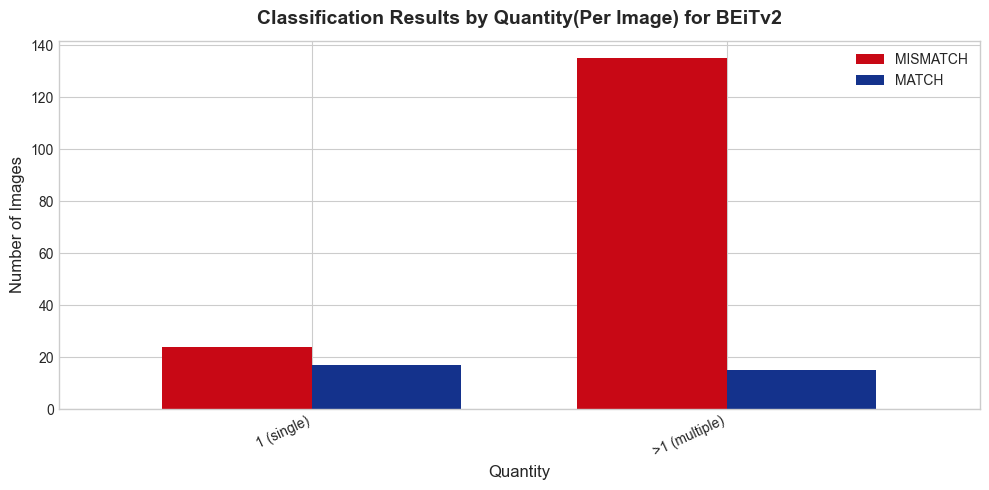

In [15]:
import matplotlib.pyplot as plt

merged["status"] = merged["prediction"] == merged["ground_truth"]
summary = merged.groupby(["gt_group", "status"]).size().unstack(fill_value=0)

preferred_order = ["0 (none)", "1 (single)", ">1 (multiple)", "Unknown"]
summary = summary.reindex([r for r in preferred_order if r in summary.index])

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]

summary.rename(columns={False: "MISMATCH", True: "MATCH"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title(f"Classification Results by Quantity(Per Image) for BEiTv2", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Quantity", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
